This notebook reproduces Figure 1 from the paper. It simulates three types of purely model-based agents: correct, transition-dependent learning rates (TDLR), and unlucky symbol. The data are analyzed and the results are plotted.

In [11]:
import random
import sys
import pickle
from os.path import join
from numba import jit
import numpy as np
from scipy.special import expit
from utils import *

# Number of trials each simulated agent will perform
NUM_TRIALS = 1000
# Model parameters: learning rate, inverse temperature, and
# second-stage value reduction caused by choosing the "unlucky symbol"
ALPHA, BETA, ETA = 0.5, 5.0, 0.5
# Different learning rates for the TDLR model
ALPHA_COMMON, ALPHA_RARE = 0.8, 0.2

The correct model-based strategy is defined below, for comparison with the other strategies.

In [12]:
@jit
def mb_correct(alpha, beta):
    """Simulation of a correct model-based strategy."""
    value = np.zeros((2, 2))
    rwrd_probs = create_random_rwrd_probs()
    choice1 = 0
    for _ in range(NUM_TRIALS):
        r = 0.4*(max(value[1]) - max(value[0]))
        prob1 = expit(beta*r)
        choice1 = int(random.random() < prob1)
        fstate = get_random_fstate(choice1)
        choice2 = int(random.random() < expit(beta*(value[fstate, 1] - value[fstate, 0])))
        reward = get_random_reward(fstate, choice2, rwrd_probs)
        value[fstate, choice2] = (1 - alpha)*value[fstate, choice2] + alpha*reward
        rwrd_probs = diffuse_rwrd_probs(rwrd_probs)
        yield (choice1, fstate, choice2, reward)

Then we define the "unlucky symbol" algorithm.

In [13]:
@jit
def mb_unlucky_symbol(alpha, beta, eta):
    """Simulation of the unlucky symbol algorithm."""
    value = np.zeros((2, 2))
    rwrd_probs = create_random_rwrd_probs()
    choice1 = 0
    for _ in range(NUM_TRIALS):
        r = 0.7*max(value[1]) + 0.3*max(value[0]) - eta*(0.3*max(value[1]) + 0.7*max(value[0]))
        prob1 = expit(beta*r)
        choice1 = int(random.random() < prob1)
        fstate = get_random_fstate(choice1)
        value_reduction = eta if choice1 == 0 else 1
        choice2 = int(random.random() < expit(value_reduction*beta*(value[fstate, 1] - value[fstate, 0])))
        reward = get_random_reward(fstate, choice2, rwrd_probs)
        value[fstate, choice2] = (1 - alpha)*value[fstate, choice2] + alpha*reward
        rwrd_probs = diffuse_rwrd_probs(rwrd_probs)
        yield (choice1, fstate, choice2, reward)

And then the transition-dependent learning rates (TDLR) algorithm.

In [14]:
@jit
def mb_tdlr(alpha_common, alpha_rare, beta):
    """Simulation of the transition-dependent learning rates model-based strategy."""
    value = np.zeros((2, 2))
    rwrd_probs = create_random_rwrd_probs()
    choice1 = 0
    for _ in range(NUM_TRIALS):
        r = 0.4*(max(value[1]) - max(value[0]))
        prob1 = expit(beta*r)
        choice1 = int(random.random() < prob1)
        fstate = get_random_fstate(choice1)
        choice2 = int(random.random() < expit(beta*(value[fstate, 1] - value[fstate, 0])))
        reward = get_random_reward(fstate, choice2, rwrd_probs)
        if choice1 == fstate: # Common transition
            alpha = alpha_common
        else:
            alpha = alpha_rare
        value[fstate, choice2] = (1 - alpha)*value[fstate, choice2] + alpha*reward
        rwrd_probs = diffuse_rwrd_probs(rwrd_probs)
        yield (choice1, fstate, choice2, reward)

The code below simulates the three types of agents below and calculates their stay probabilities and model-based weights. **Note that here we only simulate 100 agents, but for the paper we simulated 1000 agents.**

In [15]:
import pandas as pd
from fractions import Fraction

class CouldNotFitException(Exception):
    pass

def fit_model(stan_model, model_dat):
    """Fits a Stan model to data to get the maximum likelihood parameters."""
    log_lik = -np.inf
    params = None
    errors = 0
    for _ in range(10):
        while True:
            try:
                op = stan_model.optimizing(data=model_dat, as_vector=False, iter=5000)
            except RuntimeError:
                errors += 1
                if errors > 100:
                    sys.stderr.write('Could not fit model to data\n')
                    raise CouldNotFitException
                continue
            else:
                break
        if op['value'] > log_lik:
            log_lik = op['value']
            params = op['par']
    return params

class StayProbabilitiesCalculator:
    """Helper class for the stay probabilities."""
    def __init__(self):
        self.prev_reward = None
        self.prev_transition = None
        self.prev_choice = None
        self.stay = [(0, 0) for _ in range(4)]
    def add_trial_info(self, choice1, fstate, _, reward):
        if self.prev_choice is not None:
            indx = 2*self.prev_reward + self.prev_transition
            num, den = self.stay[indx]
            self.stay[indx] = (num + int(self.prev_choice == choice1), den + 1)
        self.prev_reward = reward
        self.prev_transition = int(choice1 == fstate)
        self.prev_choice = choice1
    def get_stay_prob(self, reward, transition):
        num, den = self.stay[2*reward + transition]
        return num/den

# Directory where the hybrid model's Stan implementation is saved
MODELS_DIR = 'models'
# Parameters of the hybrid model
HYBRID_PARAMS = ('alpha1', 'alpha2', 'lmbd', 'beta1', 'beta2', 'w', 'p')

MODELS = (mb_correct, mb_unlucky_symbol, mb_tdlr)
MODELS_PARAMS = {
    mb_correct: (ALPHA, BETA),
    mb_unlucky_symbol: (ALPHA, BETA, ETA),
    mb_tdlr: (ALPHA_COMMON, ALPHA_RARE, BETA),
}
MODEL_LABELS = {
    mb_correct: 'Correct',
    mb_unlucky_symbol: 'Unlucky symbol',
    mb_tdlr: 'TDLR',
}

def simulate_mb_agents(num_agents, print_progress=True):
    """Simulates model-based agents, then calculates stay probabilities and hybrid model parameters."""
    stan_model = get_stan_model(
        join(MODELS_DIR, 'hybrid_no_log_lik.stan'),
        join(MODELS_DIR, 'hybrid_no_log_lik.bin'))
    cols = HYBRID_PARAMS + ('stay_prob_11', 'stay_prob_10', 'stay_prob_01', 'stay_prob_00')
    model_results = {model: None for model in MODELS}
    for model, params in MODELS_PARAMS.items():
        if print_progress:
            print('Simulating {} agents...'.format(MODEL_LABELS[model]))
        results = []
        agents = 0
        while agents < num_agents:
            if agents%(num_agents//100) == 0:
                print(round(agents*100/num_agents, 1), end='% ')
            model_dat = {}
            s2 = []
            rewards = []
            a1 = []
            a2 = []
            spc = StayProbabilitiesCalculator()
            for choice1, fstate, choice2, reward in model(*params):
                # We sum 1 to final state, choice1 and choice2
                # because the hybrid model expects 1/2 rather than 0/1.
                s2.append(fstate + 1)
                rewards.append(reward)
                a1.append(choice1 + 1)
                a2.append(choice2 + 1)
                spc.add_trial_info(choice1, fstate, choice2, reward)
            model_dat['s2'] = s2
            model_dat['reward'] = rewards
            model_dat['a1'] = a1
            model_dat['a2'] = a2
            model_dat['T'] = NUM_TRIALS
            try:
                fitted_params = fit_model(stan_model, model_dat)
            except CouldNotFitException:
                continue
            agents += 1
            results.append([float(v) for v in fitted_params.values()] + [
                spc.get_stay_prob(1, 1),
                spc.get_stay_prob(1, 0),
                spc.get_stay_prob(0, 1),
                spc.get_stay_prob(0, 0),
            ])
        if print_progress:
            print()
        model_results[model] = pd.DataFrame(results, columns=cols)
    return model_results

# For the paper, 1000 agents of each type were simulated rather than 100
results = simulate_mb_agents(num_agents=100)

Simulating Correct agents...
0.0% 1.0% 2.0% 3.0% 4.0% 5.0% 6.0% 7.0% 8.0% 9.0% 10.0% 11.0% 12.0% 13.0% 14.0% 15.0% 16.0% 17.0% 18.0% 19.0% 20.0% 21.0% 22.0% 23.0% 24.0% 25.0% 26.0% 27.0% 28.0% 29.0% 30.0% 31.0% 32.0% 33.0% 34.0% 35.0% 36.0% 37.0% 38.0% 39.0% 40.0% 41.0% 42.0% 43.0% 44.0% 45.0% 46.0% 47.0% 48.0% 49.0% 50.0% 51.0% 52.0% 53.0% 54.0% 55.0% 56.0% 57.0% 58.0% 59.0% 60.0% 61.0% 62.0% 63.0% 64.0% 65.0% 66.0% 67.0% 68.0% 69.0% 70.0% 71.0% 72.0% 73.0% 74.0% 75.0% 76.0% 77.0% 78.0% 79.0% 80.0% 81.0% 82.0% 83.0% 84.0% 85.0% 86.0% 87.0% 88.0% 89.0% 90.0% 91.0% 92.0% 93.0% 94.0% 95.0% 96.0% 97.0% 98.0% 99.0% 
Simulating Unlucky symbol agents...
0.0% 1.0% 2.0% 3.0% 4.0% 5.0% 6.0% 7.0% 8.0% 9.0% 10.0% 11.0% 12.0% 13.0% 14.0% 15.0% 16.0% 17.0% 18.0% 19.0% 20.0% 21.0% 22.0% 23.0% 24.0% 25.0% 26.0% 27.0% 28.0% 29.0% 30.0% 31.0% 32.0% 33.0% 34.0% 35.0% 36.0% 37.0% 38.0% 39.0% 40.0% 41.0% 42.0% 43.0% 44.0% 45.0% 46.0% 47.0% 48.0% 49.0% 50.0% 51.0% 52.0% 53.0% 54.0% 55.0% 56.0% 57.0% 58.0% 

Now plot the results: (1) the idealized stay probabilities for a model-free, correct model-based, and hybrid agents, (2) the stay probabilities for the simulated unlucky symbol and TDLR agents, and (3) the model-based agents for the three types of model-based agents.

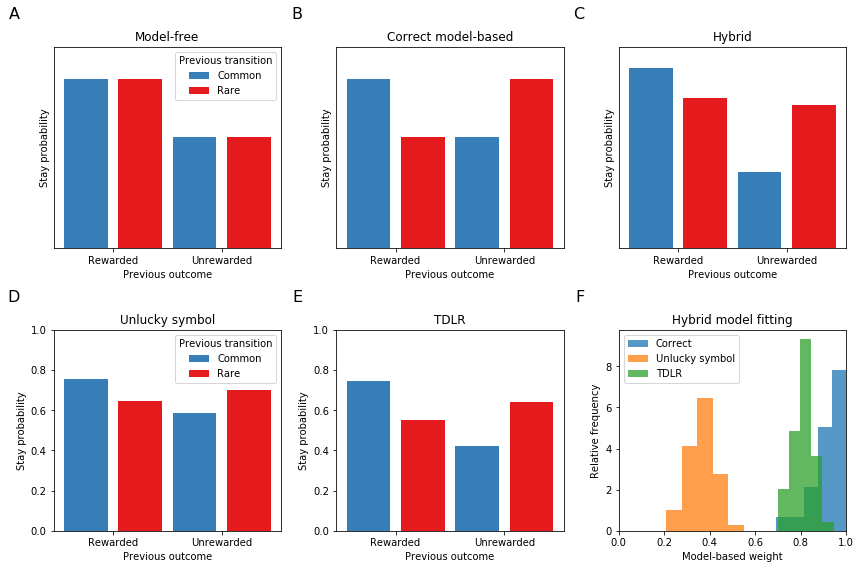

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

# Color for the stay probabilities after rare transitions (red)
COLOR_RARE = (0.8941176470588236, 0.10196078431372549, 0.10980392156862745, 1.0)
# Color for the stay probabilities after common transitions (blue)
COLOR_COMMON = (0.21568627450980393, 0.49411764705882355, 0.7215686274509804, 1.0)

def plot_results(model_results, histogram_bins=None):
    """Plot results from simulated model-based agents in comparison with idealized results."""
    plt.figure(figsize=(3*4, 2*4))
    panel_label = ord('A')
    def draw_label(ax, panel_label):
        ax.text(-0.15, 1.2, chr(panel_label), transform=ax.transAxes, fontsize=16, va='top', ha='right')
        return panel_label + 1
    models_coefs = ( # These numbers are from Decker et al. (2016)
        ('Model-free', [0.9205614508160216, 0.9205614508160216, 0.7772998611746911, 0.7772998611746911]),
        ('Correct model-based', [0.9205614508160216, 0.7772998611746911, 0.7772998611746911, 0.9205614508160216]),
        ('Hybrid', [0.9478464369215823, 0.8721384336809187, 0.6899744811276125, 0.8556968659094812]),
    )
    for i, (condition, y) in enumerate(models_coefs):
        # Plot idealized stay probabilities
        ax = plt.subplot(2, 3, i + 1)
        panel_label = draw_label(ax, panel_label)
        plt.title(condition)
        plt.ylim(0.5, 1)
        plt.bar((0, 2), (y[0], y[2]), color=COLOR_COMMON, label='Common')
        plt.bar((1, 3), (y[1], y[3]), color=COLOR_RARE, label='Rare')
        plt.xticks((0.5, 2.5), ('Rewarded', 'Unrewarded'))
        plt.yticks([])
        plt.xlabel('Previous outcome')
        plt.ylabel('Stay probability')
        if i == 0:
            plt.legend(loc='best', title='Previous transition')
    for plotnum, model in enumerate((mb_unlucky_symbol, mb_tdlr)):
        # Plot stay probabilities
        ax = plt.subplot(2, 3, plotnum + 4)
        panel_label = draw_label(ax, panel_label)
        plt.title(MODEL_LABELS[model])
        plt.xlabel('Previous outcome')
        plt.ylabel('Stay probability')
        plt.ylim(0, 1)
        y = [
            model_results[model].stay_prob_11.mean(),
            model_results[model].stay_prob_10.mean(),
            model_results[model].stay_prob_01.mean(),
            model_results[model].stay_prob_00.mean(),
        ]
        plt.bar((0, 2), (y[0], y[2]), color=COLOR_COMMON, label='Common')
        plt.bar((1, 3), (y[1], y[3]), color=COLOR_RARE, label='Rare')
        plt.xticks((0.5, 2.5), ('Rewarded', 'Unrewarded'))
        if plotnum == 0:
            plt.legend(title='Previous transition')
    # Plot histogram of weights
    ax = plt.subplot(2, 3, 6)
    panel_label = draw_label(ax, panel_label)
    plt.title('Hybrid model fitting')
    plt.ylabel('Relative frequency')
    plt.xlabel('Model-based weight')
    plt.xlim(0, 1)
    for plotnum, model in enumerate(MODELS_PARAMS.keys()):
        plt.hist(model_results[model].w, bins=histogram_bins, density=True, label=MODEL_LABELS[model], alpha=0.75)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    plt.close()

plot_results(results, histogram_bins=5)